<a href="https://colab.research.google.com/github/AashishKanted/Sales_Forecasting/blob/main/Forecasting_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sales Forecast

Using Prophet (https://facebook.github.io/prophet/)

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

Pandas library in python is used for handling the data.


##Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os
from google.colab import data_table #For interactive tables
data_table.enable_dataframe_formatter()

# Update path according to the directory in which all the files are stored
# Excel files can be stored in subfolders inside this directory also
# Add/delete any files in this directory and run 'Update Data' to include in dataframe
base_path = '/content/drive/My Drive/Forecast (Python)/'

#Installing prophet
!pip install prophet
from prophet import Prophet

#Importing matplotlib for graphing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#For Widgets
!pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display

#Update the Data
Run this everytime NEW data is available.
(No need to run if data hasn't changed since last run)

All the excel files in the path given below will be read.

This can take a while to run
(15-20 mins for retail garment store)

In [ ]:
# Function to recursively search for Excel files in subfolders
def find_excel_files(directory):
    excel_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.xlsx') or file.endswith('.xls'):
                excel_files.append(os.path.join(root, file))
    return excel_files


# Find all Excel files in the subfolders
excel_files = find_excel_files(base_path)
excel_files.remove(base_path +'forecast_result.xlsx')

# List to store the DataFrames
dataframes = []

# Read each Excel file into a separate DataFrame
for file in excel_files:
    df = pd.read_excel(file,header = None,skiprows=1, skipfooter=1)
    dataframes.append(df)

# Combine the DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)
# Add custom column header
column_names = ['Product','Brand','Section','Size','Bill date','Bill Number','MRP','Quantity','Net Amount']  # Replace with your custom column names
df.columns = column_names
df['Bill date'] = pd.to_datetime(df['Bill date'])
# Print the combined DataFrame
print(df.head())
# Use to pickle new data
df.to_pickle(base_path + 'retail_store_data.pkl') #Saved as pickle file for faster access


# Import Data
Run before each use.

To read and import the ickled data stored bu Update data

In [2]:
df = pd.read_pickle(base_path +'retail_store_data.pkl')
df.head()

,Product,Brand,Section,Size,Bill date,Bill Number,MRP,Quantity,Net Amount
0,ART MIX DHOTHIS,AJ SILKS,SILK SAREES,0,2019-11-07,KSL/256963,860.0,1.0,860.0
1,ART MIX DHOTHIS,AJ SILKS,SILK SAREES,0,2019-11-08,KSL/257785,640.0,1.0,640.0
2,ART MIX DHOTHIS,AJ SILKS,SILK SAREES,0,2019-11-29,KSL/274305,640.0,1.0,640.0
3,ART MIX DHOTHIS,KAVIN,SILK SAREES,0,2019-11-28,KSL/273558,1780.0,1.0,1780.0
4,ART MIX DHOTHIS,MSR,SILK SAREES,3.60 MTRS,2019-11-26,KSL/272290,560.0,1.0,560.0


#Forecasting
Edit the period with the number of months you want the forecast for.

Forecast is saved in a file called forecast_result.xlsx in the drive

In [ ]:
period = int(input("Enter number of months to forecast for: "))
n_top_products = int(input("Enter the number of top products to forecast for: "))
# Group sales by product and month
df['YearMonth'] = df['Bill date'].dt.to_period('M')
product_sales = df.groupby(['Product', 'YearMonth'])['Quantity'].sum().reset_index()

# Perform demand forecasting for each product
forecast_dict = {}  # Dictionary to store forecasts for each product

# Create a custom holiday dataframe
holidays = pd.DataFrame({
    'holiday': 'covid_lockdown',
    'ds': pd.to_datetime(['2020-04-01', '2020-05-01']),  # Specify the lockdown period
    'lower_window': 0,
    'upper_window': 30  # Specify the duration of the holiday in days (2 months)
})

products = product_sales['Product'].value_counts().reset_index()['index']
print(products)

for product in products[:20]:
  # Filter data for the current product and brand
  product_data = product_sales[product_sales['Product'] == product]

  data = pd.DataFrame()
  data['ds'] = product_data['YearMonth'].dt.to_timestamp().dt.strftime('%Y-%m')  # Convert to string format
  data['y'] = product_data['Quantity']
  data['floor'] = 0 #floor to remove negative data
  data['cap'] = 20000

  p = Prophet(holidays=holidays,growth = 'logistic')
  p.add_country_holidays(country_name='IN')

  try:
    model = p.fit(data)
  except:
    # Products with very few instances can't be forecasted, hence would be skipped
    print(data)
    continue

  # MS denotes month start
  future = p.make_future_dataframe(periods=period, freq='MS',include_history = False)

  future['cap']= 20000
  future['floor']= 0
  forecast = p.predict(future)

  forecast_dict[product] = forecast['yhat'].sum() #Summing the Quantity predicted for the period

#Save forecast data to Excel
writer = pd.ExcelWriter(base_path + 'forecast_result.xlsx')
pd.DataFrame.from_dict(forecast_dict, orient = "index",columns=['Qty']).reset_index().to_excel(writer, sheet_name=f'{period}_month_forecast', index=False)

writer.save()
writer.close()

# Visualisations

##Graphs Product sales by Quantity
Select the product from the drop down list (once selected it would reflect in the second box)

In [5]:
top_products = df['Product'].value_counts()
# Create a dropdown widget
dropdown = widgets.Dropdown(options=top_products.index)

# Create a text widget to display the selected option
selected_option = widgets.Text()

# Create an observer function to update the selected_option
def on_dropdown_change(change):
    selected_option.value = str(change.new)

# Attach the observer function to the dropdown widget
dropdown.observe(on_dropdown_change, names='value')

# Display the widgets
display(dropdown)
display(selected_option)



Dropdown(options=('BLOUSE', 'POONAM SAREE', 'L TOPS', 'G FORMAL SHIRT', 'GI FROCK', 'SHAWL', 'LEGINS', 'B T SH…

Text(value='')

Once the product is selected above run the code below.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6yx99r82/i7j7feqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6yx99r82/nd28cfk8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81788', 'data', 'file=/tmp/tmp6yx99r82/i7j7feqk.json', 'init=/tmp/tmp6yx99r82/nd28cfk8.json', 'output', 'file=/tmp/tmp6yx99r82/prophet_modelm93kr9v2/prophet_model-20230820142943.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


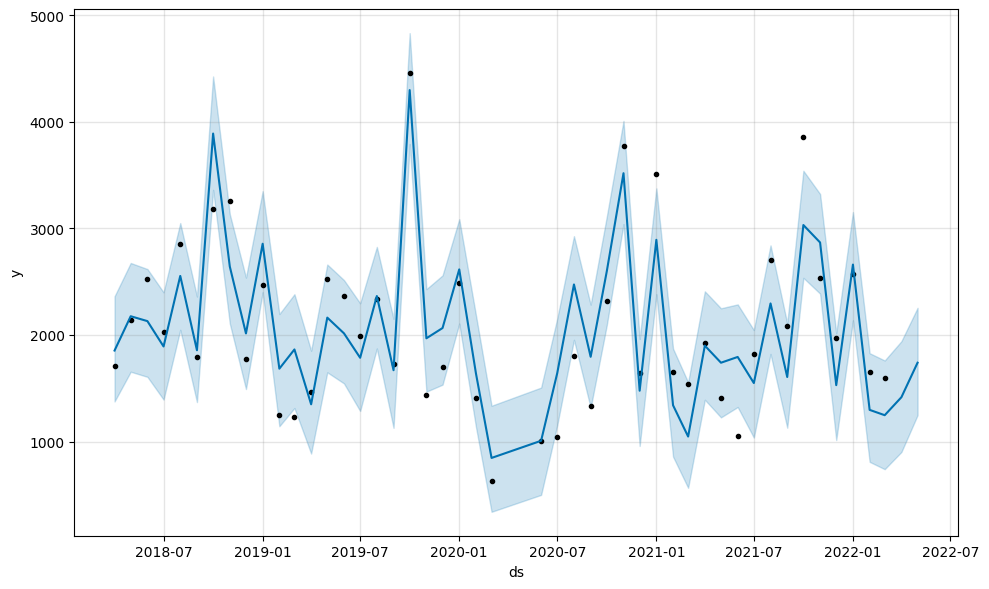

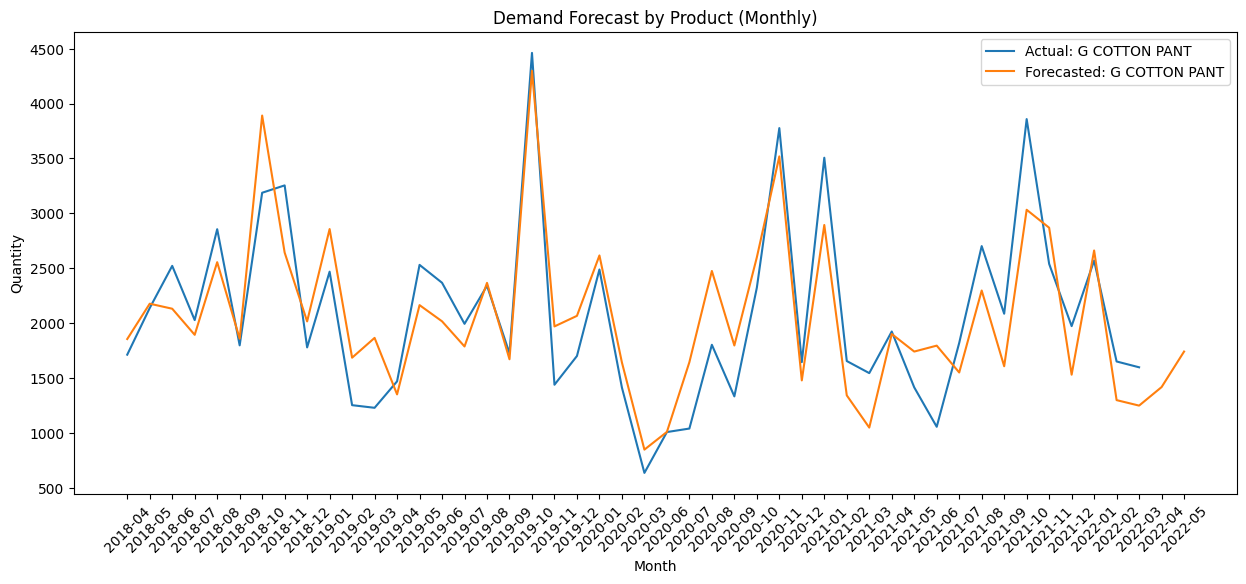

In [7]:
# Group sales by product and month
df['YearMonth'] = df['Bill date'].dt.to_period('M')
product_sales = df.groupby(['Product', 'YearMonth'])['Quantity'].sum().reset_index()

product = selected_option.value

# Filter data for the current product
product_data = product_sales[product_sales['Product'] == product]

# Prepare data for Prophet
data = pd.DataFrame()
data['ds'] = product_data['YearMonth'].dt.to_timestamp().dt.strftime('%Y-%m')  # Convert to string format
data['y'] = product_data['Quantity']
data['floor'] = 0
data['cap'] = 20000

# print(data) #to print data

# Create a custom holiday dataframe
holidays = pd.DataFrame({
    'holiday': 'covid_lockdown',
    'ds': pd.to_datetime(['2020-04-01', '2020-05-01']),  # Specify the lockdown period
    'lower_window': 0,
    'upper_window': 60  # Specify the duration of the holiday in days (2 months)
})

# Create and fit the Prophet model with the holiday
model = Prophet(holidays=holidays,growth = 'logistic')
model.fit(data)

# Generate future dates for forecasting
future = model.make_future_dataframe(periods=2, freq='MS')  # Forecasting for the next 12 months (monthly basis)
future['cap']= 20000
future['floor']= 0
# Perform forecasting
forecast = model.predict(future)

plot_1 = model.plot(forecast,plot_cap = False)

# Plot actual sales and forecasts for each product
plt.figure(figsize=(15, 6))
plt.plot(product_data['YearMonth'].astype(str), product_data['Quantity'], label='Actual: {}'.format(product))
plt.plot(forecast['ds'].dt.strftime('%Y-%m'), forecast['yhat'], label='Forecasted: {}'.format(product))

plt.title('Demand Forecast by Product (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend()

plt.show()

## Sales Analysis

Total Sales: 2489511537.9000015
Average Transaction Value: 471.1007276433513
Top 5 Selling Products:
            index  Product
0          BLOUSE   404012
1    POONAM SAREE   322196
2          L TOPS   267789
3  G FORMAL SHIRT   191583
4        GI FROCK   149213
********************


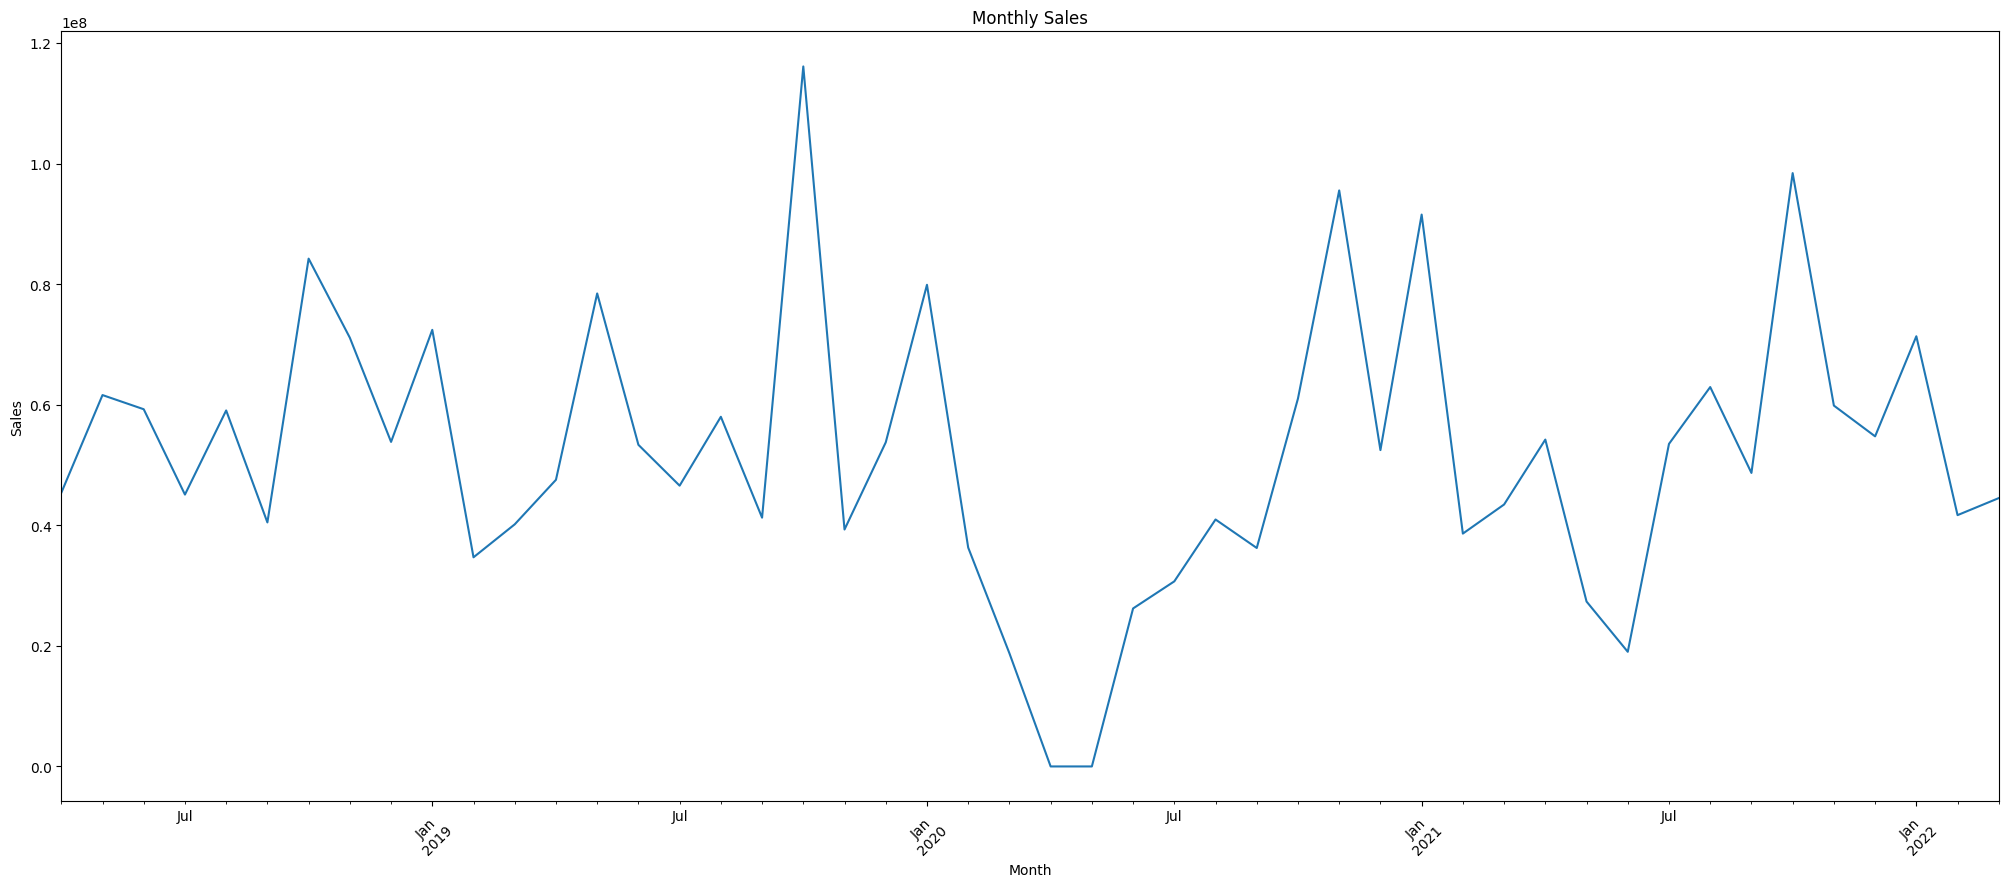

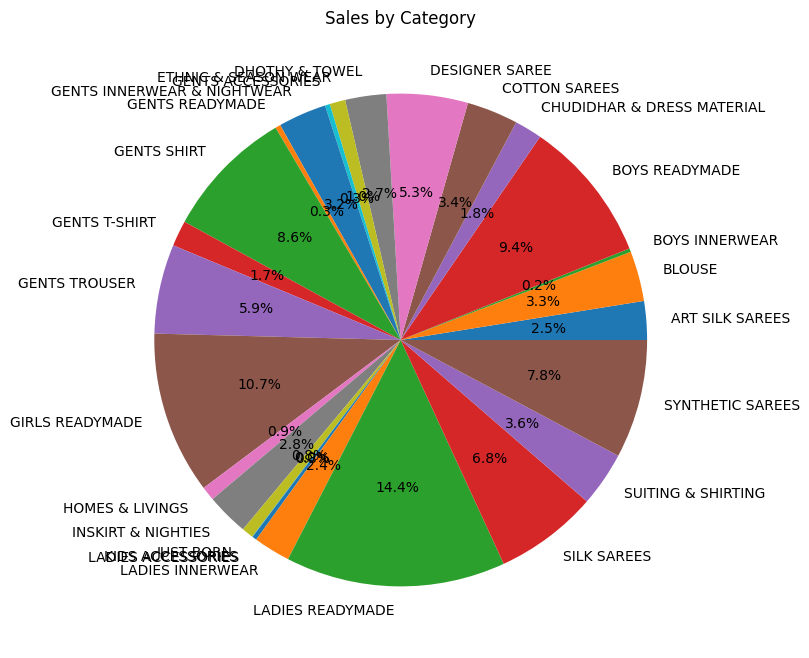

In [8]:
#Analysis 1
total_sales = df['Net Amount'].sum()
average_transaction = df['Net Amount'].mean()
top_products = df['Product'].value_counts().reset_index()

# Print the insights
print("Total Sales:", total_sales)
print("Average Transaction Value:", average_transaction)
print("Top 5 Selling Products:")
print(top_products.head(5))

print("*"*20)

# Visualization 2: Line chart for sales over time
monthly_sales = df.set_index('Bill date')['Net Amount'].resample('M').sum()
plt.figure(figsize=(25, 10))
monthly_sales.plot(kind='line')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

# Visualization 3: Pie chart for sales by product category
category_sales = df.groupby('Section')['Net Amount'].sum()
plt.figure(figsize=(8, 8))
category_sales.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sales by Category')
plt.ylabel('')
plt.show()